# Preprocessing Data

In [1]:
#import useful libraries
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm
from collections import Counter
from random import sample
from random import randint
from random import shuffle
from operator import itemgetter
from networkx.algorithms import community
from statistics import median

import random
import copy
import pickle


#### dict 'category' that contains categories and articles.

In [24]:
category = {}
with open("wiki-topcats-categories.txt") as file:
    for row in file:
        (key, value) = row.lstrip('Category:').rstrip('\n').split(";")        
        keys = value.split(" ")[1:]
        category[key] = value.split(" ")[1:]

#### create a dict where keys are the articles and values are the categories

In [3]:
inv_cat=dict()
for k,v in category.items():
    for val in v:
        inv_cat.setdefault(val,[]).append(k)


#### one article might belong to a single category or multiple ones. In the case of multiple appearance, you break the ties uniformly at random.

In [4]:

for k,v in tqdm(inv_cat.items()):
    if len(v)>1:
        inv_cat[k]=list(np.random.choice(v,size=1,replace=True))

    

100%|█████████████████████████████████████████████████████████████████████| 1791490/1791490 [00:32<00:00, 55719.42it/s]


#### save this new dict as a pickle

In [7]:
#DON'T RUN THIS IF YOU HAVE ALREADY SAVED INV_CAT.PKL ON YOUR PC
# pickle with article and relative cats
with open('inv_cat.pkl', 'wb') as handle:
    pickle.dump(inv_cat, handle)

In [5]:
with open('inv_cat.pkl', 'rb') as handle:
    inv_cat = pickle.load(handle)

#### create a dataset where each article belong to only one category

In [6]:
names=pd.read_table("wiki-topcats-page-names.txt", header=None)
names.columns=['Article']

In [7]:
names['Category']=None

In [8]:

for k,v in tqdm(inv_cat.items()):
    try:
        names.Category.iloc[[int(k)]]=v # there are key (string) that can't be converted in int
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████| 17364/17364 [00:00<00:00, 131533.61it/s]


In [ ]:
#DON'T RUN THIS IF YOU HAVE ALREADY SAVED DATASET.CSV ON YOUR PC
names.to_csv('dataset.csv', encoding='utf-8')

#### create a list with the edges

In [25]:
#list with all the articles contained in the categories that we are interested in 
article = set([i for cat in category for i in category[cat]])

In [26]:
#list with edges
edges = []

with open('wikigraph_reduced.csv','r') as f:
    for line in f:
        edge,source,target = line.rstrip('\n').split("\t")
        if source in article and target in article:
            edges.append((source,target))

In [27]:
#the first tuple (0,1), in position 0, is the header of the table, for this reason we take in consideration
#the tuples starting from position 1
edges=edges[1:] 

In [41]:
edges

[('95', '1185516'),
 ('108', '1059989'),
 ('108', '1062426'),
 ('108', '1161925'),
 ('134', '541222'),
 ('134', '1061485'),
 ('134', '1163610'),
 ('134', '1163783'),
 ('153', '744272'),
 ('153', '1064807'),
 ('153', '1065282'),
 ('153', '1085943'),
 ('153', '1125916'),
 ('153', '1130618'),
 ('153', '1161083'),
 ('153', '1162104'),
 ('153', '1162238'),
 ('167', '645690'),
 ('167', '804311'),
 ('173', '174'),
 ('173', '146870'),
 ('173', '1059766'),
 ('173', '1059906'),
 ('173', '1060905'),
 ('173', '1061638'),
 ('173', '1067692'),
 ('173', '1130481'),
 ('173', '1163227'),
 ('173', '1166373'),
 ('173', '1223897'),
 ('174', '1061112'),
 ('174', '1061313'),
 ('174', '1063717'),
 ('174', '1065339'),
 ('980', '1067601'),
 ('1086', '655218'),
 ('1086', '1063591'),
 ('1086', '1773335'),
 ('1087', '1088'),
 ('1087', '82897'),
 ('1087', '301688'),
 ('1087', '743828'),
 ('1087', '1028633'),
 ('1087', '1057862'),
 ('1087', '1062055'),
 ('1087', '1063918'),
 ('1087', '1161725'),
 ('1087', '1161782'

# RQ1

### Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them

In [6]:
#build the graph with networkx library's methods
graph = nx.DiGraph()
graph.add_edges_from(edges)

### Is the graph directed?

In [14]:
graph.is_directed()

True

As we expected, the graph is directed because between two pages we could have a hyperlink from the first page to the second one, but vice-versa is not always available.

### How many articles are we considering?

In [14]:
numb_of_nodes=graph.number_of_nodes()
numb_of_nodes

98343

The number of articles that we are considering is 98343.

### How many hyperlinks between pages exist?

In [15]:
numb_of_edges=graph.number_of_edges()
numb_of_edges

483094

In [16]:
len(edges)

483094

The is composed by 483094 edges.

### Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

In [17]:
avg_links= numb_of_edges/numb_of_nodes
avg_links

4.912337431235573

On average an article has 5 hyperlinks.

The density of a direct graph is calculated by the following formula:

$ {\ D={\frac {|E|}{2{\binom {|V|}{2}}}}={\frac {|E|}{|V|(|V|-1)}}} $

where E is the number of edges and V is the number of vertices in the graph.

Density is a value between 0 and 1. The closer to 1 the more dense.


In [18]:
density = numb_of_edges/(numb_of_nodes*(numb_of_nodes-1))
density

4.9951571365597335e-05

The result obtained is a value much closer to 0 , so it isn't a dense graph, but, as we aspected, the graph is sparse.


### Visualize the nodes' degree distribution

The degree of a node in a network is the number of connections the node has to other nodes. 
If a network is directed, meaning that edges point in one direction from one node to another node, then nodes have two different degrees, the in-degree, which is the number of incoming edges, and the out-degree, which is the number of outgoing edges.

The degree distribution ${\ P(k) }$ of a network is then defined to be the fraction of nodes in the network with degree k. Thus if there are ${\ n }$ nodes in total in a network and ${\ n_{k} }$ of them have degree ${\ k}$, we have ${\ P(k)={\frac {n_{k}}{n}}}$.

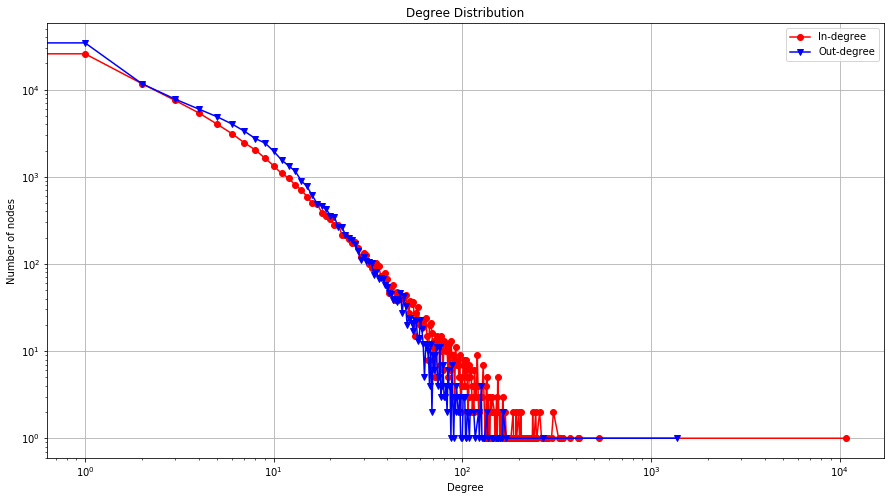

In [19]:
#in degrees
in_degrees = graph.in_degree() 
value_degree= [v for k,v in in_degrees]
in_values = sorted(set(value_degree))
in_hist = [value_degree.count(x) for x in in_values]

#out degrees
out_degrees = graph.out_degree() 
value_out_degree= [v for k,v in out_degrees]
out_values = sorted(set(value_out_degree))
out_hist = [value_out_degree.count(x) for x in out_values]

plt.figure(figsize=(15,8)) 
plt.grid(True)
plt.loglog(in_values, in_hist, 'ro-') # in-degree
plt.loglog(out_values, out_hist, 'bv-') # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.title('Degree Distribution')
plt.show()

As we can see in the graph, there are more out-connections for a high number of nodes (we think that these are the small pages of a category that have an hyperlink belong to the main pages), instead there are more in-connections for a few number of nodes (these probably are the main pages that are in-linked by the small pages, but they don't have the out-link to them).

# RQ2

In this question, we want to define a function that takes in input: a page v and a number of clicks d. The goal is to find the set of all pages that we can reach within d clicks.

We have decided to consider also in input the graph of the selected dataset. 

In [7]:
def available_pages(graph, v, d):
# graph: The graph that we working on
# v: The page that we start from
# d: Number of clicks
 
    # An empty list which suppose the be our output that consist of all the pages we visit
    seen_nodes = []
    # A list of nodes that we can see at each click
    visiting = [v]
    # A counter to save number of clicks
    counter = 0
    
    # This loop makes sure that number of clicks not exceeding the limit d
    while counter < d:
        # List of elements for the next loop
        nex_visiting = []
        # Iterate through all the nodes we can reach in a specific click
        for page in visiting:
            # If the node connects to another node, add it to nex_visiting
            if len(graph[page]) != 0:
                nex_visiting += graph[page]
            # If the node has no link to another node, add it to seen_nodes list 
            else:
                seen_nodes += [page]

        # Update the visiting list with new nodes
        visiting = nex_visiting
        # Add the pages that seen in the recent click to previous
        seen_nodes += nex_visiting
        # Update the counter
        counter += 1

    # Return the output
    return set(seen_nodes)

In [13]:
# Get the starting page from the user
v = str(input("Choose a starting page: "))
# Get the number of clicks from the user
d = int(input("Choose the number of clicks: "))
available_pages(graph, v, d)

Choose a starting page: 134
Choose the number of clicks: 1


{'1061485', '1163610', '1163783', '541222'}

We can see that the if we want to start from page 134 and we want consider only 1 distance's click, we will obtain 4 pages.

# RQ3

Define a function that takes in input:

 - A category C
 - A set of pages in C, p = {p1, ..., pn}
 
and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C.

Consider that:

 - The algorithm needs to handle the case that the graph is not connected, thus not all the pages in p are reachable from v. In such scenario, it is enough to let the program give in output the string "Not possible".
 - Since we are dealing with graph exploration, you can pass more than once on the same page pi.
 - Since the problem’s complexity is high, consider to provide just an approximation/heuristic solution for the problem.
 - You can use whatever metrics of centrality.

Create the Dataset for the question

In [2]:
wikigraph = pd.read_csv('wikigraph_reduced.csv', delimiter = '\t')
wikigraph['Unnamed: 0'] = wikigraph['0']
wikigraph.head()

,Unnamed: 0,0,1
0,95,95,1185516
1,108,108,1059989
2,108,108,1062426
3,108,108,1161925
4,134,134,541222


In [3]:
wikigraph.shape

(483094, 3)

In [4]:
dataset = pd.read_csv('dataset.csv')
dataset.head()

,Unnamed: 0,Article,Category
0,0,0 Chiasmal syndrome,Diseases_of_the_eye_and_adnexa
1,1,1 Kleroterion,Democracy
2,2,2 Pinakion,Personal_identification_documents
3,3,3 LyndonHochschildSerre spectral sequence,Group_theory
4,4,4 Zariski's main theorem,Mathematical_theorems


In [5]:
dataset.shape

(1791489, 3)

In [6]:
# Merge the dataset
new_dataset = pd.merge(dataset, wikigraph, how="left", on="Unnamed: 0" )
new_dataset.rename(columns={"0" : "Source", "1" : "Target"}, inplace=True)
new_dataset.head()

,Unnamed: 0,Article,Category,Source,Target
0,0,0 Chiasmal syndrome,Diseases_of_the_eye_and_adnexa,NaN,NaN
1,1,1 Kleroterion,Democracy,NaN,NaN
2,2,2 Pinakion,Personal_identification_documents,NaN,NaN
3,3,3 LyndonHochschildSerre spectral sequence,Group_theory,NaN,NaN
4,4,4 Zariski's main theorem,Mathematical_theorems,NaN,NaN


In [ ]:
# DO NOT RUN if you have already the new dataset
new_dataset.to_csv('dataset_with_connection.csv', encoding='utf-8')

In [2]:
df = pd.read_csv('dataset_with_connection.csv')
df.drop(columns='Unnamed: 0.1',inplace=True)
df.head()

,Unnamed: 0,Article,Category,Source,Target
0,0,0 Chiasmal syndrome,Diseases_of_the_eye_and_adnexa,NaN,NaN
1,1,1 Kleroterion,Democracy,NaN,NaN
2,2,2 Pinakion,Personal_identification_documents,NaN,NaN
3,3,3 LyndonHochschildSerre spectral sequence,Group_theory,NaN,NaN
4,4,4 Zariski's main theorem,Mathematical_theorems,NaN,NaN


In order to find the minimun number of click, we have decided to build two different function:
 
 - first: compute the shortest path between a starting point and a final point
 - second: find the number of minimum click using the selected dataset, where the dataset could be with a random selection or not.

In [20]:
# INPUT:
#       - graph: the graph of the selected dataset
#       - df: the dataset we choose
#       - Initial: the starting article
#       - Destination: the arrival article

def shortest_path(graph, df, Initial, Destination): 
    # Start to define the variables
    explored = [] 
    queue = [[Initial]] 
    # Exctract the name for the starting variables
    start_article = df.loc[df["Source"] == Initial, "Article"][:1]
    start_article = np.array(start_article)
    start_article = start_article[0]
    # Exctract the name for the destination variables
    end_article = df.loc[df["Source"] == Destination, "Article"][:1]
    end_article = np.array(end_article)
    end_article = end_article[0]
    
    if Initial == Destination: 
        print("Same Node") 
        return
    while queue:
        path = queue.pop(0) 
        node = path[-1] 
        if node not in explored: 
            neighbours = graph[node] 
            for i in neighbours: 
                new_path = list(path) 
                new_path.append(i) 
                queue.append(new_path)
                
                if i == Destination: 
                    click = len(new_path) - 1
                    print("Minimum number of clicks from {} to {} is:".format(start_article, end_article), click) 
                    return
            explored.append(node) 
    print("Minimum number of clicks from {} to {} is:".format(start_article, end_article) + " Not Possible") 
    return

The input variable "df" of the following function must have the same dimension of the csv file "dataset_with_connection.csv" because inside the following function we consider some specific columns of the dataset.

In [21]:
# INPUT:
#       - df: the dataset we choose
#       - category: the choosen category
#       - random: YES or NO if you want to consider random article inside the category or not. 

def min_num_click(df, category, random):
    # dropn NaN values and reset index in the dataframe
    df = df.dropna()
    df = df.reset_index(drop=True)
    # Generate the graph for the dataset
    general_graph = defaultdict(list) 
    for i in range(df.shape[0]):
        a, b = df.loc[i][3] , df.loc[i][4] # '3' and '4' are the columns of 'source' and 'target'
        general_graph[a].append(b)
        general_graph[b].append(a)
    
    # Select only the article in the category 
    df_category = df[df['Category'] == category]
    
    if random == 'YES':
        # Here, we take the random articles in the category
        df_random = df_category.sample(n = randint(0, len(df_category)))
        if df_random.shape[0] == 0:
            return "The Graph is not Connected"
        else:
            # Now, we create the graph for the reduced dataframe in order to find the most central article
            FG = nx.from_pandas_edgelist(df_random, source='Source', target='Target', create_using=nx.DiGraph())
            node = list(FG.nodes())
            edge = list(FG.edges())
            graph = nx.DiGraph()
            graph.add_edges_from(edge)
            degree_dict = dict(FG.degree(FG.nodes()))
            nx.set_node_attributes(FG, degree_dict, 'degree')
            # Find the centrality of each article
            degree_dict=nx.degree_centrality(FG)
            # this is not very useful, however it return the sorted centrality of the article inside the dataframe
            sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)  
            # Find the centrality of each article
            max_key = max(degree_dict, key=degree_dict.get)
            # Take the list of artcile in the category and remove multiple articles
            l = list(df_random['Source'])
            v = list(dict.fromkeys(l))
            v = np.array(v)
            # compute the shortest path
            for i in v:
                shortest_path(general_graph, df_random, max_key, i)
        return
    
    else:
        # Here, is the case in which we want all the article in the selected category
        if df_category.shape[0] == 0:
            return "The Graph is not Connected"
        else:
            # Now, we create the graph for the reduced dataframe in order to find the most central article
            FG = nx.from_pandas_edgelist(df_category, source='Source', target='Target', create_using=nx.DiGraph())
            node = list(FG.nodes())
            edge = list(FG.edges())
            graph = nx.DiGraph()
            graph.add_edges_from(edge)
            degree_dict = dict(FG.degree(FG.nodes()))
            nx.set_node_attributes(FG, degree_dict, 'degree')
            # Find the centrality of each article
            degree_dict=nx.degree_centrality(FG)
            # this is not very useful, however it return the sorted centrality of the article inside the dataframe
            sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
            # Find the centrality of each article
            max_key = max(degree_dict, key=degree_dict.get)
            # Take the list of artcile in the category and remove multiple articles            
            l = list(df_category['Source'])
            v = list(dict.fromkeys(l))
            v = np.array(v)
            # compute the shortest path
            for i in v:
                shortest_path(general_graph, df_category, max_key, i)
        return            

In [22]:
category = input()
random = input() # choose between YES (Random element) and NO (All element)
min_num_click(df, category, random)

 2000s_comedy_films
 NO


Minimum number of clicks from 1060294 Zoolander to 48712 The Parole Officer is: 4
Minimum number of clicks from 1060294 Zoolander to 136259 Wasabi Tuna is: 3
Minimum number of clicks from 1060294 Zoolander to 145905 Mystery Team is: 3
Minimum number of clicks from 1060294 Zoolander to 147508 Loveless in Los Angeles is: 4
Minimum number of clicks from 1060294 Zoolander to 252355 Outing Riley is: 3
Minimum number of clicks from 1060294 Zoolander to 326293 Tenure (film) is: 2
Minimum number of clicks from 1060294 Zoolander to 343610 Moving McAllister is: 3
Minimum number of clicks from 1060294 Zoolander to 400673 Martin & Orloff is: 3
Minimum number of clicks from 1060294 Zoolander to 428353 Outsourced (film) is: 4
Minimum number of clicks from 1060294 Zoolander to 470302 Diminished Capacity is: 3
Minimum number of clicks from 1060294 Zoolander to 479044 I Hope They Serve Beer in Hell (film) is: 4
Minimum number of clicks from 1060294 Zoolander to 526474 Visioneers is: 3
Minimum number of

We can note that in the category "2000s_comedy_films" with all the articles inside, the most center article is "1060294 Zoolander". Moreover, we can see the path to reach all the articles inside the category. 

# RQ4

Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories.

Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v?

In [18]:
# Import Dataset
dataset=pd.read_csv('dataset.csv')
dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
dataset.head()

,Article,Category
0,0 Chiasmal syndrome,Diseases_of_the_eye_and_adnexa
1,1 Kleroterion,Democracy
2,2 Pinakion,Personal_identification_documents
3,3 LyndonHochschildSerre spectral sequence,Group_theory
4,4 Zariski's main theorem,Mathematical_theorems


In [21]:
# INPUT: 
#       - cat1: the first category chose
#       - cat2: the second category chose
#       - edges: list of all the connection among the nodes

def sub_two_cat (cat1, cat2, edges):
    # select the categories 1 and 2 from the dataset
    c1=dataset[dataset['Category']==cat1]
    c2=dataset[dataset['Category']==cat2]
    # we took the node from the two catecories, which correspond to the index in the corresponding dataset
    node_1=list(c1.index)
    node_2=list(c2.index)
    # merge the node's 'dataset'
    node=node_1+node_2
    # create a list of tuples, which contains the edges among the nodes of the two selected categories
    edge_sub=[]
    for i in tqdm(edges):
        if (int(i[0]) and int(i[1])) in node:
            edge_tup=(i[0],i[1])
            edge_sub.append(edge_tup)
    # create the graph
    subgraph = nx.DiGraph()
    subgraph.add_edges_from(edge_sub)
    return subgraph

In [28]:
# Get the first category from the user
cat1 = str(input("Choose the first category: "))
# Get the second category from the user
cat2 = str(input("Choose the second category: "))
subgraph = sub_two_cat(cat1, cat2, edges)

Choose the first category: American_film_actors
Choose the second category: American_television_actors


100%|████████████████████████████████| 483094/483094 [00:56<00:00, 8520.74it/s]


##### Since nodes in the graph are as string, we have decide to give them a name as a integer from 0 to number of nodes 

In [29]:
list_name=[i for i in range(subgraph.number_of_nodes())]
count=0
for k in subgraph.nodes():
    subgraph.nodes[str(k)]['name'] = list_name[count]
    subgraph.nodes[str(k)]['weight']= 1
    count +=1

In [30]:
nx.info(subgraph)

'Name: \nType: DiGraph\nNumber of nodes: 25206\nNumber of edges: 47862\nAverage in degree:   1.8988\nAverage out degree:   1.8988'

##### Take two arbitrary pages from the graph

The following cell is at discretion of the user. However, if we decided to run this cell, we could find the following problem: the two random nodes could not be connected. Therefore, we could not find a path between this two nodes.  

In [62]:
random_nodes = random.sample(list(subgraph.nodes()), 2)
v=random_nodes[0]
u=random_nodes[1]

#### MIN CUT

In order to find the min cut we need to use three different function:
 - path_research: gives us the path among nodes;
 - bfs: gives us the shortest path between a starting node and a final node;
 - min_cut: gives us the max flow. "In computer science and optimization theory, the max-flow min-cut theorem states that in a flow network, the maximum amount of flow passing from the source to the sink is equal to the total weight of the edges in a minimum cut, i.e. the smallest total weight of the edges which if removed would disconnect the source from the sink." (https://en.wikipedia.org/wiki/Max-flow_min-cut_theorem) 

In [166]:
# INPUT:
#       - dict_neigh: is a list with the neightboring nodes from v to u (nodes as string)
#       - v: the starting node (as 'name'=integer)
#       - u: the final node (as 'name'=integer)
#       - graph: the graph associted to the dataset

def path_research(dict_neigh, v, u, graph):
    
    path = [u] #list of path from node u to v (nodes as integer->given by 'name')
    while path[-1] != v: #starting from u until we arrive to v
        for p in graph.nodes(): #for each node in graph
            if (graph.nodes[p]['name']==path[-1]):#if node p has name equal to current integer in the path
                
                x=graph.nodes[dict_neigh[p]]['name'] #correspondig integer to node p
                path.append(x) #update path
                
    path.reverse() #list of path from v to u
    return path


In [167]:
# INPUT:
#       - v: the starting node (as 'name'=integer)
#       - u: the final node (as 'name'=integer)
#       - graph: the graph associted to the dataset

def bfs(graph,v,u):
    
    visited_nodes=[] #list of visited nodes
    node_queue=[] #list of nodes in queue to go across 
    path=[] #list of path
    dict_neigh={} #dict of neighbors of each node
    node=v
    flag=False # exit condition
    visited_nodes.append(node)  
    node_queue.append(node)  
    while node_queue:
        first = node_queue.pop(0) #take first element in queue
        
        for neighbor in nx.neighbors(graph, first): #research neighbors of node 'first' 
            if neighbor not in visited_nodes: # if neighbor isn't already visited
                dict_neigh[neighbor]=first #update dict of neightboring nodes
                visited_nodes.append(neighbor) #update list of visited nodes
                node_queue.append(neighbor) # update queue

                if neighbor==u: #when we arrive to the final node
                    
                    path = path_research(dict_neigh,graph.nodes[v]['name'],graph.nodes[u]['name'], graph) #calculating path from node v to node u
                    
                    flag=True 
                    break
                                 
    return path, flag

In [189]:
# INPUT:
#       - v: the starting node (as 'name'=integer)
#       - u: the final node (as 'name'=integer)
#       - graph: the graph associted to the dataset

def min_cut(graph,v,u):
    
    path_flow=float('Inf')
    graph_copy=graph.copy() #copy of the graph because we need to delete edges, but we don't want modify the original graph.
    path,flag= bfs(graph_copy,v,u)
    max_flow=0

    while flag:
        
        i=0
        while i < len(path)-1:
            
            for p in graph_copy.nodes():
                if graph_copy.nodes[p]['name']==path[i]: #search the node(as string) which has 'name' equal to integer in the path
                    x=p #save the node as a string
            for n in graph_copy.nodes():
                if graph_copy.nodes[n]['name']==path[i+1]: #search the node(as string) which has 'name' equal to integer in the path
                    y=n #save the node as a string
                    
            #check the direction of the edge to remove and remove it   
            if graph_copy.has_edge(x,y) and graph_copy.nodes[x]['weight']==1:
                path_flow=min(path_flow,graph_copy.nodes[x]['weight'])
                graph_copy.remove_edge(x,y)
                print('rimosso edge da %s a %s' %(x,y))
                max_flow+=path_flow
            if graph_copy.has_edge(y,x) and graph_copy.nodes[y]['weight']==1:
                path_flow=min(path_flow,graph_copy.nodes[y]['weight'])
                graph_copy.remove_edge(y,x)
                print('rimosso edge da %s a %s' %(y,x))
                
                max_flow+=path_flow
            
            path,flag = bfs(graph_copy,v,u)
            
    if max_flow==0:
        return print('No path exists between this 2 arbitrary page')
    else:
        return max_flow


If we have decided to take two random nodes (see the cell above), we will substitute '1061485' with the random v's node and '1061888' with the random u's node.
We advice to not considet two random nodes because the path between them could not exist.  

In [191]:
min_cut(subgraph,v='1061485',u='1061888')

rimosso edge da 1061485 a 1060768
rimosso edge da 1060768 a 1061485
rimosso edge da 1061485 a 1061445
rimosso edge da 1061485 a 1061902
rimosso edge da 1061485 a 1265376
rimosso edge da 1265376 a 1061485
rimosso edge da 1061485 a 1061564
rimosso edge da 1061485 a 1061463


8

The min_cut from '1061485' to '1061888' is equal to 8

# RQ5

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

In [2]:
# Import the dataset with the connection associeted at each article
df = pd.read_csv('dataset_with_connection.csv')
df.drop(columns='Unnamed: 0.1',inplace=True)
df.head()

,Unnamed: 0,Article,Category,Source,Target
0,0,0 Chiasmal syndrome,Diseases_of_the_eye_and_adnexa,NaN,NaN
1,1,1 Kleroterion,Democracy,NaN,NaN
2,2,2 Pinakion,Personal_identification_documents,NaN,NaN
3,3,3 LyndonHochschildSerre spectral sequence,Group_theory,NaN,NaN
4,4,4 Zariski's main theorem,Mathematical_theorems,NaN,NaN


In [3]:
# Reduce the dimension of the dataset by deleting the article without connection
df1 = df.dropna()
df1 = df1.reset_index(drop=True)
df1.head()

,Unnamed: 0,Article,Category,Source,Target
0,95,95 This Way (Hana Pestle album),Debut_albums,95.0,1185516.0
1,108,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1059989.0
2,109,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1062426.0
3,110,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1161925.0
4,136,134 San Quentin (1937 film),American_films,134.0,541222.0


Now, we define the two function that we use to find the distance between the two categories:

 1: a function to compute the shortest path between a starting point and an ending point

2: a function that compute the median among the distance in each catories from the select one and that put the result in a dataframe. The distance is computed using the following formula:
 
                         distance(C_0, C_i) = median(ShortestPath(C_0, C_i))

In [4]:
# INPUT:
#      - graph: the graph associated at our dataset
#      - Initial: the starting article
#      - Destination: the end article

def shortest_path(graph, Initial, Destination): 
    explored = [] 
    queue = [[Initial]] 
            
    while queue:
        path = queue.pop(0) 
        node = path[-1] 
        if node not in explored: 
            neighbours = graph[node] 
            for i in neighbours: 
                new_path = list(path) 
                new_path.append(i) 
                queue.append(new_path)
                if i == Destination: 
                    click = len(new_path) - 1
                    return click
            explored.append(node) 
    click = 100 # if there is not connection between the initial and the destion we put 100
    return click

In [5]:
# INPUT:
#      - df: the select dataset
#      - graph: the associated graph at the dataset
#      - category: the selected category
#      - order: True or False if we want the final value sorted or not

def distance(df, graph, category, order):
    # Delete the Nan value
    df1 = df.dropna()
    df1 = df1.reset_index(drop=True)
    
    general_graph = graph
    
    # Excract the list of article inside the selected category
    df_C0 = df1[df1['Category'] == category]
    l_C0 = list(df_C0['Source'])
    v_C0 = list(dict.fromkeys(l_C0))
    v_C0 = np.array(v_C0)
    
    # Create a list with all the remain category
    cat_list = list(df1['Category'])
    cat = [x for x in cat_list if x != category]
    cat = list(dict.fromkeys(cat))
    categories = np.array(cat)
    
    # create empty vector to store the distance and the median
    distance = []
    Median = []
    med = []
    # Start the loop for the categories
    for z in tqdm(categories):
        df_C1 = df1[df1['Category'] == z]
        l_C1 = list(df_C1['Source']) # list of article inside the category
        v_C1 = list(dict.fromkeys(l_C1)) # delate duplicates article
        v_C1 = np.array(v_C1) # transform the article in array
        for i in v_C0:
            for j in v_C1:
                distance.append(shortest_path(general_graph, i, j))
        if len(distance) == 0:
            med == 100
        else:
            med = median(sorted(distance)) # compute the median
        
        distance.clear() # clear the distance variable
        Median.append(med)
    
    # create a dataframe with the category and the article
    category_df = pd.DataFrame(list(zip(categories, Median)), columns = ['Category', 'Distance'])
    category_df = category_df.sort_values(by='Distance', ascending=order)
    return category_df

Since our dataset is too big and the running time for the distance function could be huge because it is based on the number of article inside the selected category. Hence, if our selected category (C_0) has inside - for example - 10 articles and one of the other category (C_1) has inside - for example - 20 articles, then we perform for the first article in C_0 10 distances, for the second article other 10 and so on for a total of 200 distances. 

In [13]:
# Delete the Nan value
df2 = df.dropna()
df2 = df2.reset_index(drop=True)
    
# Create the graph for the all the dataset
graph = defaultdict(list) 
for i in tqdm(range(df2.shape[0])):
    a, b = df2.loc[i][3] , df2.loc[i][4] # '3' and '4' are the columns of source and target
    graph[a].append(b)
    graph[b].append(a)

100%|██████████| 483094/483094 [02:30<00:00, 3219.89it/s]


We have decided to consider two different approach to perform this task:
 - first approach: we consider the first n rows of the dataset 
 - second approach: we take n rows at random from the dataset

#### First Approach

In [35]:
df_head = df1.head(100)
df_head.head()

,Unnamed: 0,Article,Category,Source,Target
0,95,95 This Way (Hana Pestle album),Debut_albums,95.0,1185516.0
1,108,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1059989.0
2,109,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1062426.0
3,110,108 Born Innocent (Redd Kross album),Debut_albums,108.0,1161925.0
4,136,134 San Quentin (1937 film),American_films,134.0,541222.0


In [36]:
# count the number of article inside each category
df_g = df_head.groupby(by=["Category"]).count()
df_g

,Unnamed: 0,Article,Source,Target
Category,,,,
1943_films,11,11,11,11
1952_films,9,9,9,9
1979_films,7,7,7,7
1980_films,1,1,1,1
1980s_drama_films,8,8,8,8
...,...,...,...,...
ltic_F.C._players,1,1,1,1
lumbia_University_faculty,1,1,1,1
mputer_programmers,1,1,1,1


In [34]:
category = input()
order = input() #True: if ascending order ||| False: if in decreasing order
df_category = distance(df_head, graph, category, order)#, upper_threshold)
df_category

 American_film_actors
 Yes


100%|██████████| 15/15 [1:00:27<00:00, 241.86s/it]


,Category,Distance
14,"People_from_Evanston,_Illinois",4.0
1,American_films,5.0
2,English-language_films,5.0
4,1985_films,5.0
5,Deaths_from_myocardial_infarction,5.0
7,"People_from_Austin,_Texas",5.0
10,Actors_from_Florida,5.0
11,"People_from_Union_County,_New_Jersey",5.0
13,American_television_actors,5.0
0,Debut_albums,6.0


We can see that for this approach the computational time is 1 hour and we consider only the first 100 rows and 15 categories. We select as starting category 'American_film_actors' and in the table above is shown the distance results. We can see that the most closer category is 'People_from_Evanston,_Illinois', with 4 click of distance. On the other hand, the category 'American_Jews' is not connected with the selected category (the number 100 means that the category is not connected).

#### Second Approach

In [55]:
df_random = df1.sample(n = 100) # we take 100 rows at random from the dataset
df_random.head()

,Unnamed: 0,Article,Category,Source,Target
75851,593889,537035 James Mackenzie Maclean,UK_MPs_18861892,537035.0,536754.0
195339,1198726,1058156 Brittany Snow,"People_from_Tampa,_Florida",1058156.0,1063997.0
284787,1290735,1064759 The Animal,English-language_films,1064759.0,1377378.0
155145,1050011,939699 One Hour in Wonderland,English-language_films,939699.0,1162781.0
253356,1258426,1062279 Walk the Line,American_drama_films,1062279.0,1065232.0


In [ ]:
# count the number of article inside each category
df_r = df_random.groupby(by=["Category"]).count()
df_r

In [61]:
category = input()
order = input() #True: if ascending order ||| False: if in decreasing order
df_category = distance(df_random, graph, category, order)#, upper_threshold)
df_category

 American_films
 True


100%|██████████| 80/80 [1:40:08<00:00, 75.10s/it]   


,Category,Distance
39,"People_from_Chicago,_Illinois",2.0
46,Actors_from_Oklahoma,2.0
47,People_from_the_Greater_Los_Angeles_Area,2.0
33,Films_based_on_novels,2.0
61,People_self-identifying_as_alcoholics,2.0
...,...,...
48,Rivers_of_the_Siret_subbasin,6.0
4,Germany_under-21_international_footballers,6.0
6,English_footballers,7.0
30,UK_MPs_18311832,7.0


We can see that for this approach the computational time is 1 hour and 40 minutes and we take 100 rows at random from the initial dataset. Then, we find 80 categories. We select as starting category 'American_films' and in the table above is shown the distance results. We can see that the most closer category is 'People_from_Evanston,_Illinois', with 2 click of distance. On the other hand, the category 'Rivers_of_the_Some_subbasin' is farthest with a distance of 7 click. In this case, we can note that all the categories are connected. 

# RQ6

Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.

The function pagerank computes a ranking of the nodes in the graph based on the structure of the incoming links.

In [2]:
# INPUT:
#       - D: is the graph
#       - alpha: is the dumping parameter for the page rank
#       - max_iter: the maximum number of iteration
#       - weight: is the edges weight between among the nodes

def pagerank(D, alpha=0.85, max_iter=100, weight=None): 

    # Create a copy in (right) stochastic form 
    W = nx.stochastic_graph(D, weight=weight) 
    N = W.number_of_nodes() 

    x = dict.fromkeys(W, 1.0 / N) # start dict
    #personalization dict with a key for every graph node and nonzero personalization value for each node.
    p = dict.fromkeys(W, 1.0 / N) 

    dangling_weights = p # weight for the nodes without out connection

    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0] #nodes without out connection

    for _ in tqdm(range(max_iter)): 
        xlast = x 
        x = dict.fromkeys(xlast.keys(), 0) 
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes) 
        for n in x: 

            # this matrix multiply looks odd because it is 
            # doing a left multiply x^T=xlast^T*W 
            for nbr in W[n]: 
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight] 
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n] 
    return x 
    

In [10]:
page_rank_art=pagerank(graph)

100%|████████████████████████████████████████| 100/100 [03:05<00:00,  1.86s/it]


The 'page_rank_art' gives us the score of the page rank based on the articles since our graph has a building block the articles. Therefore, we start to create a new dictionary 'page_rank_cat', where for each category we will have the relative page rank score

In [47]:
page_rank_cat = {key: [] for key,val in category.items()}

100%|████████████████████████████████| 17364/17364 [00:00<00:00, 667466.09it/s]


In [48]:
#dict where key=category, val=score for each article belong to the category
for k,v in tqdm(page_rank_art.items()):
    if k in inv_cat.keys():
    
        val=inv_cat[k]
        
        page_rank_cat[val[0]].append(v)
    

100%|████████████████████████████████| 98343/98343 [00:00<00:00, 317010.75it/s]


In [49]:
#update dict where key=category, val=total score 
for k,v in page_rank_cat.items():
    page_rank_cat[k]=sum(v)

In [50]:
#create new dict deleting category with no score
pr_def={key: val for key,val in page_rank_cat.items() if val != 0}

In [67]:
dataf= pd.DataFrame(pr_def.items(), columns=['category', 'score'])

In [68]:
dataf.sort_values('score', axis=0, ascending=False) 

,category,score
2648,Main_Belt_asteroids,0.086491
3741,American_film_actors,0.038927
405,Living_people,0.036722
2454,Rivers_of_Romania,0.029915
3359,English-language_films,0.028931
...,...,...
1101,Dungeons_&_Dragons_game_designers,0.000002
1093,Members_of_the_Linnean_Society_of_London,0.000002
4454,Indiana_Republicans,0.000002
4455,Indiana_lawyers,0.000002


The page rank score must be in the range $[0,1]$. We can see that the highest score is equal to $0.086491$, which belongs to the category 'Main_Belt_asteroids'. Since the highest value is still a very low value, we can say what we have also said in question 1: **the graph is sparse.**